# Normalizing Flows

In this notebook, we will explain how normalizing flows work! Then, we will build some flows and test them on small datasets.

# Intro

Normalizing flows are generative models. These models try to learn the probability distribution of a given dataset. For example, given a dataset with handwritten digits for example, normalizing flow models try to learn a probability distribution that generated these digits.

Whys is this useful? Because having this probability distribution allows us to do two things:
1. Estimate the probability – plausibility of new, unseen data points. For example, if a new image has a low likelihood, then it’s unlikely that it’s a digit, and we should reject it.
2. Create new digit images. Normalizing flows not only learn a distribution, but also allow us to sample from it – e.g. draw points that follow this distribution. Thus, we can generate new digit images. This is similar to what other models like GANs do. 

Unfortunately, probability distributions of real-world data like images or language are extremely complicated, and don’t follow simple models like the Gaussian. This is where normalizing flows come in: starting from a simple probability distribution such as a Gaussian, they apply a series of transformations on it, so that the final output has the desired distribution of the training data. The parameters of these transformations are learned from data. 

This happens in the figure below, where a simple normal distribution is transformed into a complicated one (figure from [1]):

![title](normalizing-flow.png)

To explain how this works, we need to know what happens on a distribution when we apply a transformation on it. We discuss this next.

# Probability Distributions

Let $X \in \mathbb{R}^d$ be a random variable in $d$ dimensions. A we know, if $X$ follows a probability distribution (or density) $p(x)$, then that means that the probability of $X$ taking a value in an infinitesimal volume element $d\mathbf{x} = dx_1...dx_d$ around a value $\mathbf{x} \in \mathbb{R}^d$ is given by $Prob(X \in d\mathbf{x}) = p(\mathbf{x})d\mathbf{x}$.  

Now, consider a function $f : \mathbb{R}^d \rightarrow \mathbb{R}^d$, mapping points from $\mathbb{R}^d$ into $\mathbb{R}^d$. If $X$ follows the density $p(X)$, then what is the distribution of $Y = f(X)$? If $f$ is an invertible function (e.g. that means that the inverse function $f^{-1}$ is defined), then the new density $p(Y)$ satisfies the following property: 

$$ p(\mathbf{y})d\mathbf{y} = p(\mathbf{x})d\mathbf{x} $$

Here, $\mathbf{y} = f(\mathbf{x})$, and $d\mathbf{y}$ is the volume element that $f$ maps the points of $d\mathbf{x}$ into. 

This is easy to prove: since $f$ takes $\mathbf{x}$ into $\mathbf{y}$, and the points in $d\mathbf{x}$ into $d\mathbf{y}$, then the probability that $Y$ lies inside $d\mathbf{y}$ must be the same that the probability that $X$ lies inside $d\mathbf{x}$! So we get: 
$$Prob(X \in d\mathbf{x}) = Prob(Y \in d\mathbf{y}) \Leftrightarrow p(\mathbf{y})d\mathbf{y} = p(\mathbf{x})d\mathbf{x}$$
An example is shown in the image below for the 1D case (from [2]).

![title](flow1.png)

Now, the final thing we need to know is the relation between the volume elements $d\mathbf{x}$ and $d\mathbf{y}$. This is given by the Jacobian theorem (https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant), which says that:

$$ d\mathbf{y} = |det(J_f(\mathbf{x}))| d\mathbf{x} $$

Here, $J_f(\mathbf{x})$ is the Jacobian matrix of $f$ at $\mathbf{x}$, and its entries are given by: $J_{i,j} = \frac{\partial f_i (\mathbf{x})}{\partial x_j}$. Then we take the determinant of this matrix (its absolute value). We will also abuse notation sometimes and write the Jacobian as $J = f’(\mathbf{x})$.

So, putting these together, we can find the probability density of $Y$ as:
$ p(\mathbf{y})d\mathbf{y} = p(\mathbf{x})d\mathbf{x} $ and $ d\mathbf{y} / d\mathbf{x} = |det(J_f(\mathbf{x}))| $, hence: 
$$p(\mathbf{y}) = p(\mathbf{x}) \frac{1}{|det(J_f(\mathbf{x}))|} $$ 
Finally, given the $\mathbf{y}$, we have that $\mathbf{x} = f^{-1}(\mathbf{y})$, so the formula finally becomes:

\begin{equation}
\tag{1}
p(\mathbf{y}) = p(f^{-1}(\mathbf{y})) \frac{1}{|det(J_f(f^{-1}(\mathbf{y})))|} = p(f^{-1}(\mathbf{y})) \frac{1}{|det(f'(f^{-1}(\mathbf{y})))|}
\end{equation}

In the same way, since $f$ is invertible, we can apply the same formula to go from then density of $Y$ to the density of $X$. It's the same thing, we just set $g = f^{-1}$ and apply the above formula for $g$. 

# Composing transformations 

In normalizing flows, the transformation $f$ is a member of some parametric family: $f(\mathbf{x}) = f(\mathbf{x}; \theta)$, depending on some parameters $\theta$. We stack a series of $n$ such transformations, and for each of them, we want to learn the right parameter $\theta_i$, so that the final density of $Y = f_n(f_{n-1}...f_1(Z)..)$ is the correct one. $Z$ is the input random variable, which follows as simple pre-defined distribution, such as a Gaussian.  

Formula (1) still applies here, because Jacobians, similarly to normal derivatives, satisfy the chain rule: $(f(g(\mathbf{x})))’ = f’(g(\mathbf{x})) \cdot g’(\mathbf{x})$. In this way, if we have for example a series of two transformations, $Y = f(g(X))$, we can still compute the Jacobian using the chain rule, and apply the transformation formula (1) as before.

Assume now that we have trained a normalizing flow, and found the parameters $\theta_i$. Now, we can do the two things promised before:
1. Sampling: We simply draw samples from the input Gaussian, $Z \sim N(0, I_d)$, and transform them as $Y = f_n(f_{n-1}...f_1(Z)..)$. Then, the output $Y$ will have the desired probability density of the training data (and will look like digits for example).
2. Density estimation: Given a new input $\mathbf{x}$, we can apply the transformation backwards and find the corresponding $\mathbf{z}$. But then, the density of $Z$ is known (Gaussian), and the Jacobians are also known because we computed them. Thus, we can apply formula (1) and find the probability density of the new point $\mathbf{x}$. 

# Training

So, the final thing remaining is how do we train a normalizing flow. That is, given some input data $\mathbf{x}^{(j)} \in D, j=1,…,m$, how do we find the density $p(\mathbf{x})$ that approximates them? This, is done, as usual, with maximum likelihood. That is, we want to find the parameters $\theta_i$ that maximize the log-likelihood of observing these points:

$$\max_\varphi \frac{1}{|D|} \sum_{\mathbf{x}^{(j)} \in D} \log p(\mathbf{x}^{(j)})$$

where $\varphi = \lbrace \theta_1,…, \theta_n \rbrace$ are the model’s parameters. We can compute $p(\mathbf{x}) $ using formula (1) for every data-point $\mathbf{x}$, and we find the parameters that maximize it. In this way we can find a distribution that approximates the one of our dataset. Also, notice that labels are not used here.

So, now we know how to build and train a flow model, and we can make our own! For more detailed information, please check out the references at the end. 

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.distributions.multivariate_normal import MultivariateNormal

import nflow_utils as nf 

Set also the device (cpu or cuda).

In [2]:
device = 'cuda'
# device = 'cpu'  # uncomment this line to run the model on the CPU

# Model 1: Affine tranformation

An affine tranformation scales each dimension independently and shifts the inputs by a constant. The tranformation is defined as follows:

$$f(\mathbf{z})= \exp(\mathbf{a}) \odot \mathbf{z} + \mathbf{b}$$

where parameters $\mathbf{a} \in \mathbb{R}^{d}$ and $\mathbf{b} \in \mathbb{R}^{d}$. 
We apply $\exp$ elementwise to $\mathbf{a}$ to obtain positive scales for each dimension. 

Note that we can compute the inverse of this transformation analytically.

Generally, for a given transformation $f$ there are two things we need to implement first: its forward method, taking us from $\mathbf{x}$ to $\mathbf{y} = f(\mathbf{x})$, and the inverse, taking us from $\mathbf{y}$ to $\mathbf{x} = f^{-1}(\mathbf{y})$. We do that below, and also calculate the corresponding Jacobians along the way, because we will need them later. 

Namely, we have: $J_{i,j} = \frac{\partial f(\mathbf{z})_i}{\partial \mathbf{z}_j} = \frac{\partial e^{a_i}z_i}{\partial \mathbf{z}_j}$. We now see that it's $J_{i,j} = 0$ if $i \neq j$, and $e^{a_i}$ if $i = j$. So, the Jacobian is the diagonal matrix $J = diag(e^{a_1}, ..., e^{a_d})$. The determinant of this is simply $det(J) = e^{a_1}e^{a_2}...e^{a_d} = e^{a_1 + ... +a_d}$. So, finally the $log$ of this is just $a_1 + ... +a_d$. 

In [3]:
class Affine(nf.Flow):
    '''Affine transformation y = e^a * x + b.'''

    def __init__(self, dim=2):
        '''
        create and init an affine transformation.

        Input:
            dim: dimension of input/output data (int)
        '''
        
        super().__init__()
        self.dim = dim
        self.log_scale = nn.Parameter(torch.zeros(self.dim))  # a
        self.shift = nn.Parameter(torch.zeros(self.dim))  # b

    def forward(self, x):
        '''
        compute the forward transformation given an input x.

        Input:
            x: input sample; shape [batch_size, dim]

        Output:
            y: sample after forward tranformation; shape [batch_size, dim]
            log_det_jac: log determinant of the jacobian of the forward tranformation; shape [batch_size]
        '''
        # compute y directly from affine formula
        y = x * self.log_scale.exp() + self.shift
        # the log(det(J)) is simply the sum of the a_i's, and we expand this along the batch
        # dimension (e.g. suma_i -> [suma_i, ..., sum_ai]) beacuse it's the same for all x in
        # the batch
        log_det_jac = self.log_scale.sum().expand(x.shape[0])
        
        return y, log_det_jac

    def inverse(self, y):
        '''
        compute the inverse transformation given an input y.

        Input:
            y: input sample; shape [batch_size, dim]

        Output:
            x: sample after inverse tranformation; shape [batch_size, dim]
            inv_log_det_jac: log determinant of the jacobian of the inverse tranformation; shape [batch_size]
        '''
        # for x, we reverse the affine transform
        # y = e^a * x + b <=> x = (y - b) * e^(-a) 
        x = (y - self.shift) * self.log_scale.neg().exp()
        # log(det(|J|)) is the same, just with minus, because we have a new affine transform,
        # but with -a_i instead of a_i
        inv_log_det_jac = -self.log_scale.sum().expand(y.shape[0])

        return x, inv_log_det_jac
# end class

# Radial tranformation

We will also implement the radial flow from the original paper ([3]). The transformation is defined as:

$$f(\mathbf{z}) =  \mathbf{z} + \beta h(\alpha, r)(\mathbf{z} - \mathbf{z_0})$$

where $r= \|\mathbf{z} - \mathbf{z_0}\|_2$, $h(\alpha, r) = \frac{1}{\alpha + r}$ and parameters $\mathbf{z_0} \in \mathbb{R}^{d}$, $\alpha \in \mathbb{R}_+$ and $\beta \in \mathbb{R}$. The parameters need to satisfy the constraints $\alpha > 0$ and $\beta \geq -\alpha$ for the transformation to be invertible. 

To enfore the above constraints in practice, we can do the following:

- Define a learnable parameter $\tilde{\alpha} \in \mathbb{R}$ and obtain $\alpha$ for the transformation as $\alpha = \textrm{softplus}(\tilde{\alpha})$.
- Define a learnable parameter $\tilde{\beta} \in \mathbb{R}$ and obtain $\beta$ for the transformation as $\beta =-\alpha + \textrm{softplus}(\tilde{\beta}) > -\alpha$.

 Calculating the formula for $det(J)$ needs a bit of algebra, but it's already done in the paper:
$$  |det(J)| = [1 + \beta h(a,r)]^{d-1} [1 + \beta h(a,r) + \beta h’(a,r) r] $$ 
Note here that $h’(a,r) = \frac{dh}{dr} = - \frac{1}{(a+r)^2} = - \frac{1}{h^2(a, r)}$

In [18]:
class Radial(nf.Flow):
    '''Radial transformation'''

    def __init__(self, dim=2):
        '''
        create and initialize an affine transformation

        Input:
            dim: dimension of input/output data, int
        '''
        super().__init__()
        self.dim = dim
        self.x0 = nn.Parameter(torch.Tensor(self.dim,)) # Vector used to parametrize z_0 
        self.pre_alpha = nn.Parameter(torch.Tensor(1,)) # Scalar used to indirectly parametrize \alpha
        self.pre_beta = nn.Parameter(torch.Tensor(1,)) # Scaler used to indireclty parametrize \beta
        
        stdv = 1. / np.sqrt(self.dim)
        self.pre_alpha.data.uniform_(-stdv, stdv)
        self.pre_beta.data.uniform_(-stdv, stdv)
        self.x0.data.uniform_(-stdv, stdv)

    def forward(self, x):
        '''
        compute the forward transformation for the given input x.
        
        Input:
            x: input sample, shape [batch_size, dim]

        Output:
            y: sample after forward tranformation; shape [batch_size, dim]
            log_det_jac: log determinant of the jacobian of the forward tranformation; shape [batch_size]
        '''
        # compute a and b from a_tilde and b_tilde as described above
        alpha = F.softplus(self.pre_alpha)
        beta = -alpha + F.softplus(self.pre_beta)
        # compute y = f(z) from the formula
        diff = x - self.x0
        # get batch-wise norm
        r = diff.norm(dim=-1, keepdim=True)
        h = 1. / (alpha + r)
        y = x + beta * h * diff
        # compute the jacobian
        # we simply take the log of the formula above
        # we use torch.log1p(x) = torch.log(1 + x), because it's more accurate for small inputs x
        h_prime = - (h ** 2) # h'
        log_det_jac = ((self.dim - 1) * torch.log1p(beta * h) + torch.log1p(beta * h + beta * h_prime * r)).sum(-1)
        return y, log_det_jac
    
    def inverse(self, y):
        '''
        compute the inverse transformation given an input y.

        Input:
            y: input sample; shape [batch_size, dim]

        Output:
            x: sample after inverse tranformation; shape [batch_size, dim]
            inv_log_det_jac: log determinant of the jacobian of the inverse tranformation; shape [batch_size]
        '''
        raise ValueError('The inverse tranformation is not known in closed form')
# end class

# Stacking transformations

Now it's time to stack multiple transformations together. To do this, we need to compute the total forward and inverse transformations. For that, we will apply the formula for the Jacobian of the transformation composition discussed previously.

To clarify this a bit better, we will consider an example of two stacked transforms, $Y = f(g(X)) = h(X)$, and discuss how to compute the forward and inverse.

For the forward part, we can apply formula (1) for h and take logs:

$p(\mathbf{y}) = p(h^{-1}(\mathbf{y})) \frac{1}{|det(h'(h^{-1}(\mathbf{y}))}$

But $h^{-1}(\mathbf{u}) = g^{-1}(f^{-1}(\mathbf{u}))$ and 
$h'(\mathbf{u}) = f'(g(\mathbf{u})) \cdot g'(\mathbf{u})$

But the determinant of a matrix product is the product of the determinants, hence:

$det(h'(\mathbf{u})) = det(f'(g(\mathbf{u})))  det(g'(\mathbf{u})) \Rightarrow log|det(h'(\mathbf{u}))| = log|det(f'(g(\mathbf{u})))| + log|det(g'(\mathbf{u}))|$

Setting now $\mathbf{u} = h^{-1}(\mathbf{y}) = g^{-1}(f^{-1}(\mathbf{y}))$, the above becomes:

$ log|det(h'(g^{-1}(f^{-1}(\mathbf{y}))))| = log|det(f'(g(g^{-1}(f^{-1}(\mathbf{y})))))| + log|det(g'(g^{-1}(f^{-1}(\mathbf{y}))))| $ or

$ log|det(h'(g^{-1}(f^{-1}(\mathbf{y}))))| = log|det(f'(f^{-1}(\mathbf{y})))| + log|det(g'(g^{-1}(f^{-1}(\mathbf{y}))))| $

Observing this formula carefully, we see that the following happens: we apply the inverse transforms backwards, and at each step we calculate the Jacobian on that step, and add it to the current sum. At the end, the sum will be equal to the log of the combined Jacobian.

Thus, we can work out the transform with the following algorithm: <br>
$logJ \leftarrow 0$, $\mathbf{z} = \mathbf{y}$ <br>
for $T$ in $reverse(Transforms)$: <br>
$ \quad    z, inv\_log\_det\_jacob = T.inverse(z)$ <br>
$ \quad   logJ \leftarrow logJ + inv\_log\_det\_jacob $ <br>
$log\_pz = log(base(z))$ <br>
$pog\_py = log\_pz - logJ$

Finally, another useful property is that the Jacobian determinants of the forward and inverse functions are related in the following way:

$|det(f'^{-1}(\mathbf{y}))| = \frac{1}{|det(f'(f^{-1}(\mathbf{y})))|}$

In [5]:
class StackedFlows(nn.Module):
    def __init__(self, transforms, dim=2, base_dist='Normal'):
        '''
        stack a list of tranformations with a given base distribution

        Input:
            tranforms: list fo stacked tranformations; list of Flows
            dim: dimension of input/output data; int
            base_dist: name of the base distribution. options: ['Normal']
        '''
        super().__init__()
        
        # check if provided transforms are valid
        if isinstance(transforms, nf.Flow):
            self.transforms = nn.ModuleList([transforms, ])
        elif isinstance(transforms, list):
            if not all(isinstance(t, nf.Flow) for t in transforms):
                raise ValueError("transforms must be a Flow or a list of Flows")
            self.transforms = nn.ModuleList(transforms)
        else:
            raise ValueError(f"transforms must a Flow or a list, but was {type(transforms)}")
            
        self.dim = dim
        # for now, input distributions are only Gaussian
        if base_dist == "Normal":
            self.base_dist = MultivariateNormal(torch.zeros(self.dim).to(device), torch.eye(self.dim).to(device))
        else:
            raise NotImplementedError

    def log_prob(self, x):
        '''
        compute log probability of a batch of data

        Input:
            x: input sample; shape [batch_size, dim]

        Output:
            log_prob: Log probability of the data; shape [batch_size]
        '''
        
        # go through the transforms list in reverse order, and apply the inverse to find the 
        # previous point. Finally, when we arrive at the base, compute p(z)
        # also, the Jacobian of the entire transform is the product of the Jacobians
        # Jall = J1 * J2 * ... * Jn => [det(AB) = det(A)det(B)]
        # det(Jall) = det(J1) det(J2) ... det(Jn) => |det(Jall)| = |det(J1)| |det(J2)| ... |det(Jn)|
        # => log|det(Jall)| = log|det(J1)| + ... + log|det(Jn)|
        # so, to get the log det of the combined transform, we add the log dets along the way!
        inv_log_det = 0.0
        for transform in reversed(self.transforms):
            z, inv_log_det_jacobian = transform.inverse(x)
            inv_log_det += inv_log_det_jacobian
            x = z
        log_base = self.base_dist.log_prob(x)
        # the final formula is p(z) = p(y) / det|Jall| (we go from y to z)
        # taking logs we get log(p(y)) = log(p(z)) + log(det|Jall|)
        log_prob = (inv_log_det + log_base)
        
        return log_prob

    def rsample(self, batch_size):
        '''
        sample from the transformed distribution

        Returns:
            x: sample after forward tranformation; shape [batch_size, dim]
        '''
        
        # get a sample from the base
        x = self.base_dist.rsample([batch_size])
        log_base = self.base_dist.log_prob(x)
        log_det = 0.0
        # now apply the forward transform to go from z to x
        # compute also the combined log det Jacobian by summing the log dets along the way 
        # as before
        for transform in self.transforms:
            x, log_det_jacobian = transform.forward(x)
            log_det += log_det_jacobian
        # the final formula is p(y) = p(z) / det|Jall| from (1) => log(p(y)) = log(p(z)) - log(det|Jall|)
        log_prob = - log_det + log_base
        
        return x, log_prob

# Training

After these, we're ready for training! We implement the training function below, which simply get a batch of data, calculated their negative log-likelihood, and then we minimize it by gradient descend. 

In [6]:
def train(model, dataset, batch_size=100, max_epochs=1000, frequency=250):
    '''
    train a normalizing flow model with maximum likelihood.

    Input:
        model: normalizing flow model; Flow or StackedFlows
        dataset: dataset containing data to fit; Dataset
        batch_size: number of samples per batch; int
        max_epochs: number of training epochs; int
        frequency: frequency for plotting density visualization; int
        
    Output:
        model: trained model; Flow or StackedFlows
        losses: loss evolution during training; list of floats
    '''
    # Load dataset
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
    # Train model
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
    for epoch in range(max_epochs + 1):
        total_loss = 0
        for batch_index, (X_train) in enumerate(train_loader):
            # compute log-likelihood of x from the flow model
            log_probs = model.log_prob(X_train.to(device))
            # the loss is the (mean) negative log-likelihood
            loss = -log_probs.mean(0)
            
            # make gradient step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss      
        total_loss /= len(train_loader)
        losses.append(total_loss)
        
        # print logs
        if epoch % frequency == 0:
            print(f"Epoch {epoch} -> loss: {total_loss.item():.2f}")
            nf.plot_density(model, train_loader, device=device)
    
    return model, losses

# Results

Now we can train our flows! We will train on three small datasets: a single Gaussian, a mixture of 3 Gaussians, and a dataset of two moons. We will plot the obtained distribution (density) during the training set, and see how well it fits. Note that the affine flow is linear, and thus it can only shift and scale the input distribution but not transform it further. As such, it should fail in some cases.

## Dataset 1: single Gaussian

The first dataset is composed of one Gaussian with a given mean. All flows should manage to fit this density. 

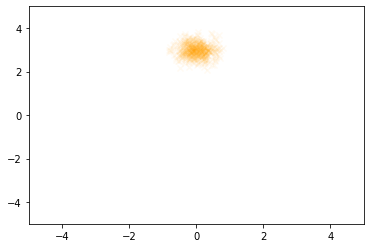

In [7]:
dataset_1 = nf.CircleGaussiansDataset(n_gaussians = 1, n_samples = 500)
plt.scatter(dataset_1.X[:,0], dataset_1.X[:,1], alpha = 0.05, marker = 'x', c = 'orange')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

### Affine flow

Epoch 0 -> loss: 6.34


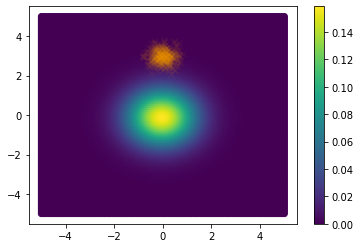

Epoch 250 -> loss: 2.46


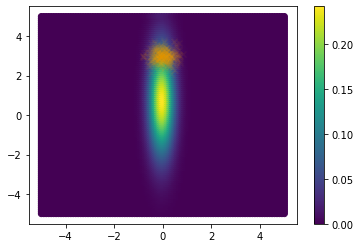

Epoch 500 -> loss: 2.04


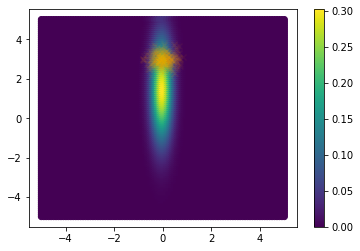

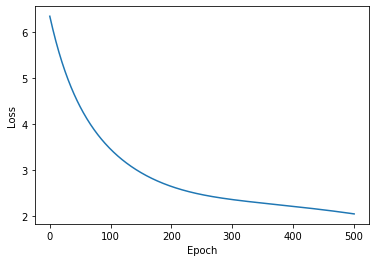

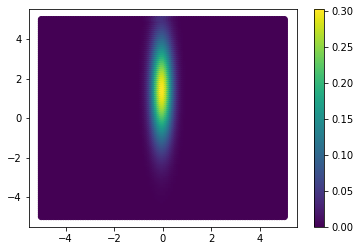

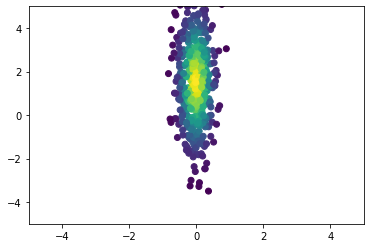

In [8]:
transforms = [Affine().to(device)]
model = StackedFlows(transforms, base_dist='Normal').to(device)
model, losses = train(model, dataset_1, max_epochs=501)

# Plots
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
nf.plot_density(model, [], device=device)
nf.plot_samples(model)

### Radial flow

Now we try a radial flow, with 4 layers:

Epoch 0 -> loss: 5.74


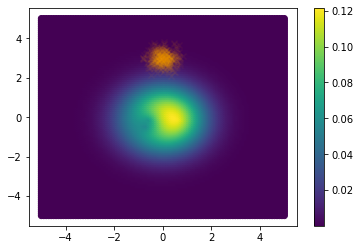

Epoch 250 -> loss: 2.98


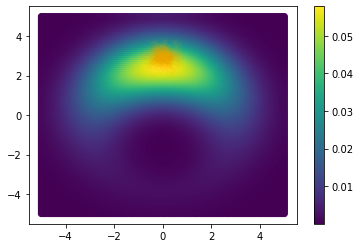

Epoch 500 -> loss: 2.70


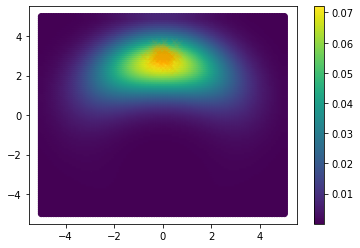

Epoch 750 -> loss: 2.55


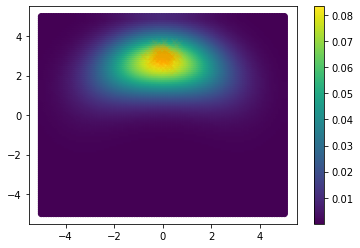

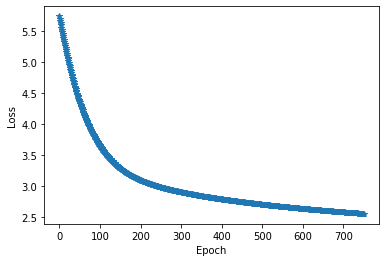

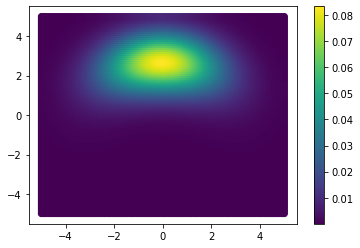

In [14]:
transforms = [Radial().get_inverse().to(device) for _ in range(4)]
model = StackedFlows(transforms, base_dist='Normal').to(device)
model, losses = train(model, dataset_1, max_epochs=750)

# Plots
plt.plot(losses, marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
nf.plot_density(model, [], device=device)

## Dataset 2: 3 Gaussians

The second dataset is composed of 3 gaussians with means on a circle's perimeter.

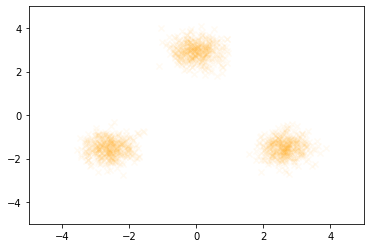

In [16]:
dataset_2 = nf.CircleGaussiansDataset(n_gaussians = 3, n_samples = 400, variance = 0.4)
plt.scatter(dataset_2.X[:,0], dataset_2.X[:,1], alpha=.05, marker='x', c='orange')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

### Affine flow

Epoch 0 -> loss: 6.45


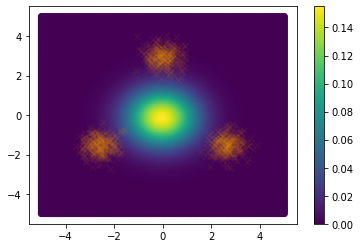

Epoch 250 -> loss: 4.37


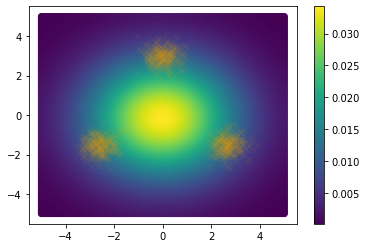

Epoch 500 -> loss: 4.37


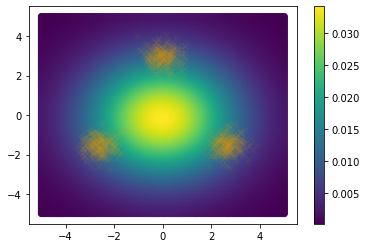

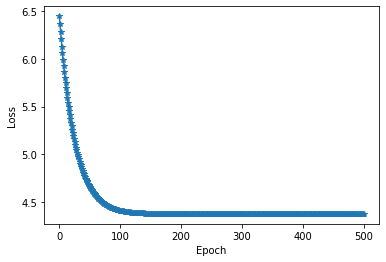

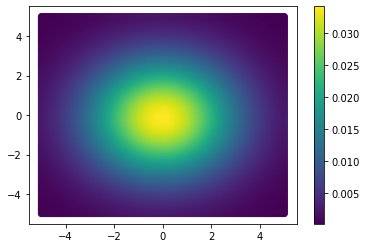

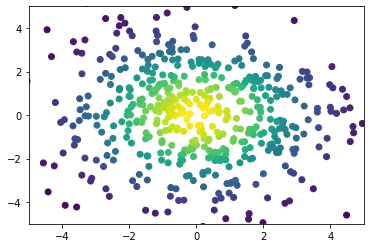

In [17]:
transforms = [Affine().to(device)]
model = StackedFlows(transforms, base_dist = 'Normal').to(device)
model, losses = train(model, dataset_2, max_epochs = 500)

# Plots
plt.plot(losses, marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
nf.plot_density(model, [], device=device)
nf.plot_samples(model)

We see that the affine flow fails here, because it can only shift and scale the input Gaussian, but not transform it into a mixture. So it tried to put the mean at the center of the circle and widen-up the std in order to "catch" more samples, but it can't fit them any further.

### Radial flow (32 layers)

Epoch 0 -> loss: 5.80


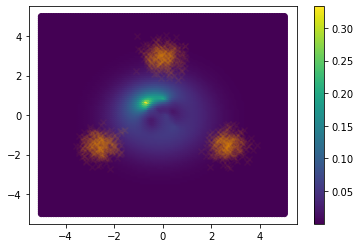

Epoch 100 -> loss: 2.86


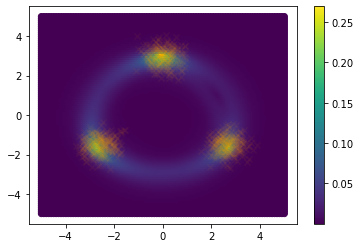

Epoch 200 -> loss: 2.44


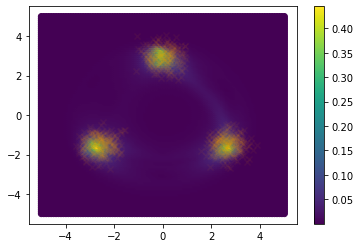

Epoch 300 -> loss: 2.30


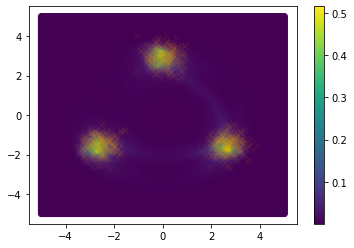

Epoch 400 -> loss: 2.25


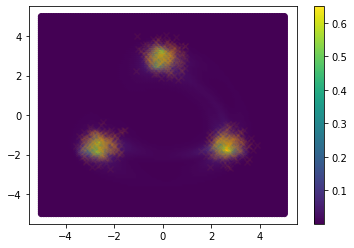

Epoch 500 -> loss: 2.22


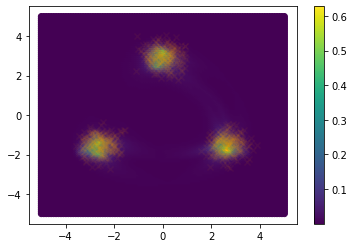

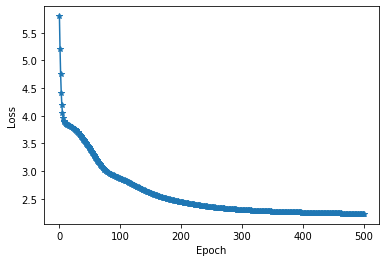

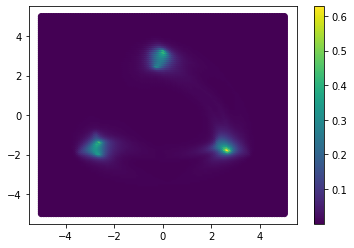

In [19]:
transforms = [Radial().get_inverse().to(device) for _ in range(32)]
model = StackedFlows(transforms, base_dist = 'Normal').to(device)
model, losses = train(model, dataset_2, max_epochs = 500, frequency = 100)

# Plots
plt.plot(losses, marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
nf.plot_density(model, [], device=device)

We see that the radial flow with 32 layers achieves a reasonable result. But it can also fail sometimes, for example learn only the 2 of 3 Gaussians, etc.

## Dataset 3: 2 Moons

The third dataset is composed of 2 moons:

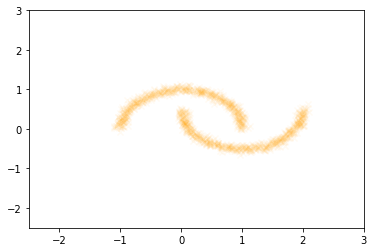

In [20]:
dataset_3 = nf.MoonsDataset()
plt.scatter(dataset_3.X[:,0], dataset_3.X[:,1], alpha = 0.05, marker='x', c = 'orange')
plt.xlim(-2.5, 3)
plt.ylim(-2.5, 3)
plt.show()

### Affine flow 

Epoch 0 -> loss: 2.49


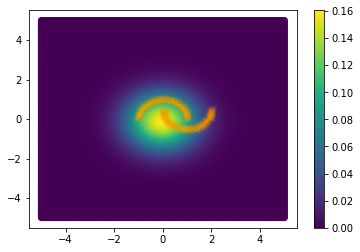

Epoch 250 -> loss: 2.00


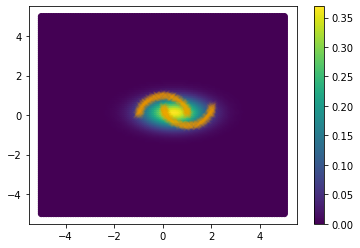

Epoch 500 -> loss: 2.00


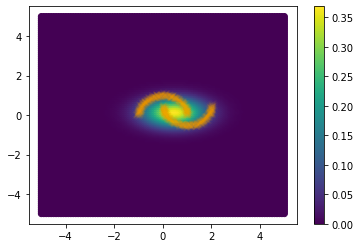

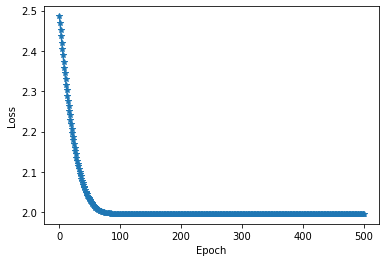

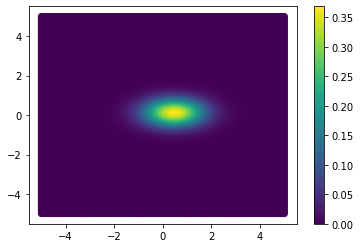

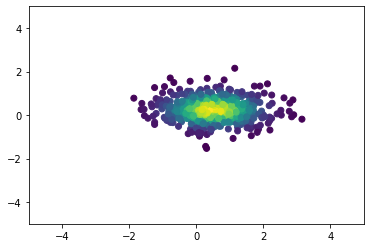

In [21]:
transforms = [Affine().to(device)]
model = StackedFlows(transforms, base_dist='Normal').to(device)
model, losses = train(model, dataset_3, max_epochs = 500)

# Plots
plt.plot(losses, marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
nf.plot_density(model, [], device=device)
nf.plot_samples(model)

The affine flow fails again, as expected.

### Radial flow (32 layers)

Epoch 0 -> loss: 2.88


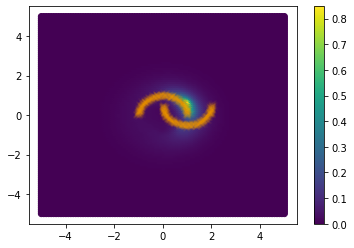

Epoch 100 -> loss: 1.37


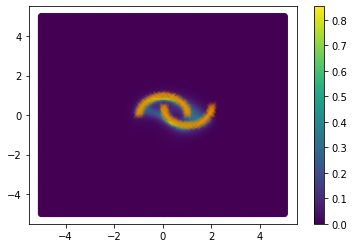

Epoch 200 -> loss: 1.10


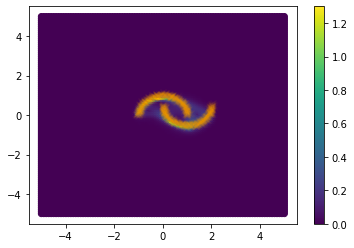

Epoch 300 -> loss: 1.01


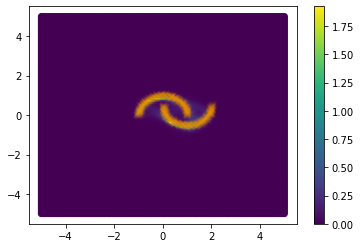

Epoch 400 -> loss: 0.96


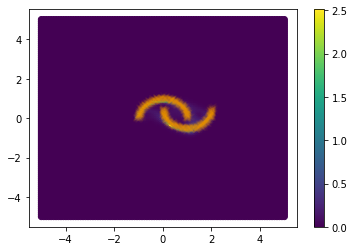

Epoch 500 -> loss: 0.91


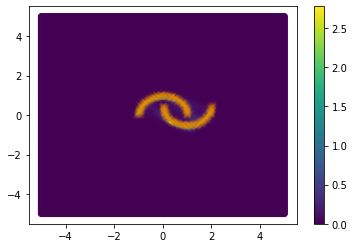

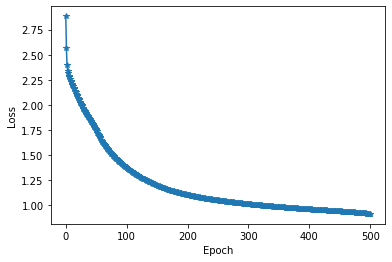

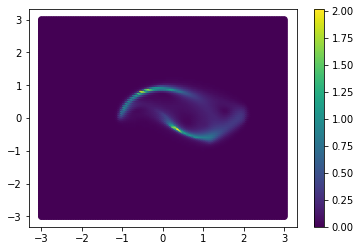

In [22]:
transforms = [Radial().get_inverse().to(device) for _ in range(32)]
model = StackedFlows(transforms, base_dist='Normal').to(device)
model, losses = train(model, dataset_3, max_epochs = 500, frequency = 100)

# Plots
plt.plot(losses, marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
nf.plot_density(model, [], mesh_size=3, device=device)

The redial flow achieves a better result, which will improve using more layers and epochs.

# Conclusion

In the above, we implemented two normalizing flow types (affine and radial) and run them on some small 2D datasets. <br> 
An advantage of normalizing flows is that they’re very easy to sample from and to get the densities of new points. This is due to the fact that all transforms used must be invertible. <br> 
The downside of this is that the input must necessarily have the same dimension as the output (which is typically high – dimensional, as almost all real – world datasets). This comes with an increased model size. Alternative types of generative models such as variational autoencoders (VAEs) or GANs do not have this issue, but are harder to use for estimating densities or sampling. 

# References

1. Lilian Weng's blog: https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html
2. Eric Jang's blog: https://blog.evjang.com/2018/01/nf1.html
3. D. J. Rezende, S. Mohamed: "Variational Inference with Normalizing Flows", ICML 2015. URL: https://arxiv.org/abs/1505.05770